In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, precision_recall_curve

In [ ]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
submission = pd.read_csv("Data/gender_submission.csv")
train.Fare.min()

In [104]:
def createModel(df , n):
    df['Sex'] = df['Sex'].replace({'male': 1, 'female': 0})
    df["Embarked"] = df["Embarked"].fillna(0)
    df["Age"] = df["Age"].fillna(df.Age.mean())
    df['Embarked'] = df['Embarked'].replace({'S': 3, 'C': 2 , 'Q':1})
    df = df.drop(["Name" , "Ticket" , "Cabin"], axis=1)
    if n == 2:
        return df[["PassengerId", "Pclass", "Age", "Sex","SibSp", "Parch", "Fare", "Embarked" ]].set_index("PassengerId") , df[["PassengerId" , "Survived"]].set_index("PassengerId")
    else:
        return df[["PassengerId", "Pclass", "Age", "Sex","SibSp", "Parch", "Fare", "Embarked"]].set_index("PassengerId")

In [ ]:
X_train , y_train = createModel(train,2)
X_test = createModel(test,1)


In [ ]:
clf = RandomForestClassifier()
parametrs = {
    "n_estimators":range(1,100,5),
    "criterion":["gini", "entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,50),
    "min_samples_leaf":range(1,50)
}
search = RandomizedSearchCV(clf, parametrs, cv=5, n_jobs=-1)
search.fit(X_train, y_train)
best_forest = search.best_estimator_

In [109]:
y_predict = pd.DataFrame(X_test.reset_index()["PassengerId"])
y_predict["Survived"] = best_forest.predict(X_test)
pd.DataFrame(classification_report(submission["Survived"], y_predict["Survived"], target_names=['Non-churned', 'Churned'], output_dict=True))

,Non-churned,Churned,accuracy,macro avg,weighted avg
precision,0.923611,1.000000,0.947368,0.961806,0.951389
recall,1.000000,0.855263,0.947368,0.927632,0.947368
f1-score,0.960289,0.921986,0.947368,0.941137,0.946360
support,266.000000,152.000000,0.947368,418.000000,418.000000


In [108]:
result = test['PassengerId'].to_frame()
result['Survived'] = (best_forest.predict(X_test))
result[['PassengerId', 'Survived']].to_csv(f'predict.csv', index=False)

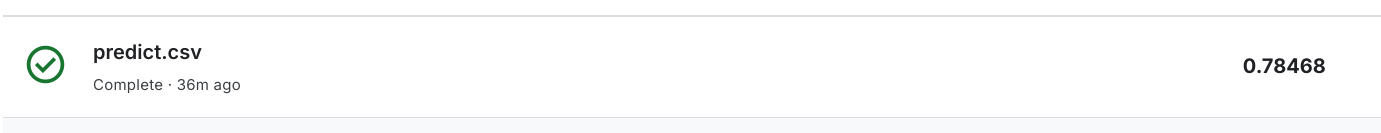